## 1.- Functional groups and bonds from gaseous IR spectrum

We are going to build a deep learning model using pytorch, for the detection of presence or absense of certain types of bonds/functional groups, from the IR spectrum of a compound.

The database can be purchased here https://www.nist.gov/srd/nist-standard-reference-database-35. It contains 5308 compound IR spectrums.

First step is to prepare the data, so we will look at the entire database, one by one and asign each compound a vector of nine values of zeros and ones, representing the bonds/fuctional groups present in the molecule. The 9 bonds/functional groups selected are: c=c, c☰c, Carboxilic Acid, c☰N, Non cyclic Ester, ketone, O-H, Carbonyl and primary Amine, for example:

![alternative text](./assets/99-96-7 vectorizacion.jpg)

This vector will be our target and the absorbance values of each one of the compounds will be our input. The database looks something like this:.

![alternative text](./assets/dataframe.jpg)

Now we will get on with the coding and import a few libraries

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import time
import math
import random

## Data prep
Let's load the dataframe and save absorbances and bond vector to two separate lists.

In [2]:
df=pd.read_pickle('df.plk')

#bonds

bonds=[]
for x in range(4836):
    bonds.append(df.iloc[x,0])
    
#absorbances


absor=[]
for x in range(4836):
    ab_values=[]
    for y in range(1,826):
        ab_values.append(df.iloc[x,y])
    absor.append(ab_values)


Create a dataset class to contain and handle the two lists as tensors

In [3]:
class dataset(Dataset):
    def __init__(self, bonds, absorbances):
        self.x=torch.tensor(absorbances).view(-1,1,825)
        self.y=torch.tensor(bonds).type(torch.FloatTensor) 
        self.len=len(bonds)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

Create an instance of the dataset class asigning it our two lists, and then randomly split the data in to training set and validation set. No Test will be used, mostly due to the size of the dataset.

The final accuracy of the model was abtained from the performance on the validation set. This can sometimes not be good practice, due to the overfitting effect a human can have at the moment of tunning hyperparameters.

In [4]:
data=dataset(bonds=bonds, absorbances=absor)

train_set, val_set= torch.utils.data.random_split(data, [3869, 967], generator=torch.Generator().manual_seed(42))

Now lets create a trainloader and validationloader instance to see how the data will be plugged into the neural net, to make sure the shape is correct. Shape should be the input shape of a 1d conv layer (batch size, num input channels, length of sequence)

In [5]:
train_loader=DataLoader(dataset=train_set, batch_size=40)
val_loader=DataLoader(dataset=val_set, batch_size=69)

#one example, this has batch_size sets

print('absorbance: ', list(train_loader)[0][0])
print('bonds: ', list(train_loader)[0][1])

absorbance:  tensor([[[3.6960e-04, 3.6520e-04, 3.2560e-04,  ..., 0.0000e+00,
          2.0240e-04, 5.3240e-04]],

        [[1.6640e-04, 1.2800e-04, 6.4000e-05,  ..., 7.2352e-03,
          3.5680e-03, 1.4432e-03]],

        [[5.1540e-03, 5.1969e-03, 5.1540e-03,  ..., 1.0523e-02,
          1.4045e-02, 1.6149e-02]],

        ...,

        [[1.4000e-04, 1.3000e-04, 1.4000e-04,  ..., 1.6500e-04,
          2.4000e-04, 4.5500e-04]],

        [[1.8900e-04, 1.9320e-04, 1.7640e-04,  ..., 1.9740e-04,
          2.4360e-04, 3.1080e-04]],

        [[2.4320e-04, 1.4440e-04, 1.4440e-04,  ..., 0.0000e+00,
          1.5960e-04, 3.4960e-04]]])
bonds:  tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 

## Neural Net 

The following diagram contains the operations performed on a 1 layer convolution with 1 input channel(the Spectra), n output channels(activation maps).

![alternative text](./assets/1DConvolution.jpg)


The convolution ends at the activation maps and the pooling starts afterwards. 

Both convolution and pooling are represented with a stride of 1 (Meaning the amount of values jumped to fill each value for the activation map or the pooled vector), and a kernel size of 3 (Meaning the amount of values taken to fill out each value for the activation map or the pooled vector), the convolution kernel is represented by the Fluorescent green box, and the pooling kernel by the light blue box.

K are the weigths of the kernel, each out channel or activation map being built from the spectrum values is "built" by using a certain set of weights (or numbers), these weights change during training, each channel will be a representation of a different feature of the input, for example, one kernel might be good at detecting peaks, of course these "features" can be highly complex. 

Our network will have 2 convolutional + pooling layers stacked one after the other, and the final number of pooled vectors is concatenated and passed though three fully connected layers with 9 output neurons with sigmoid activations to force the number to be between 0 and 1.



In [6]:
def conv_output_size(Lin, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    size = floor( ((Lin + (2 * pad) - ( dilation * (kernel_size - 1) ) - 1 )/ stride) + 1)
    return size

Next we define the structure using nn.Module

In [7]:
class cnn(nn.Module):
    def __init__(self, out_1, out_2, conv_o_size, p):
        super(cnn,self).__init__()
        self.cnn1=nn.Conv1d(in_channels=1, out_channels=out_1, kernel_size=4, stride=1, padding=0)
        self.maxpool1=nn.MaxPool1d(kernel_size=3, stride=1)
        
        self.cnn2=nn.Conv1d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=0)
        self.maxpool2=nn.MaxPool1d(kernel_size=3, stride=1)
        
        
        self.dropout=nn.Dropout(p)
        self.linear=nn.Linear(conv_o_size*out_2, 3000)
        self.dropout2=nn.Dropout(p=0.3)
        self.linear2=nn.Linear(3000, 1000)
        self.dropout3=nn.Dropout(p=0.3)
        self.linear3=nn.Linear(1000, 9)

        
        
    def forward(self, x):
        x=self.cnn1(x)
        x=torch.relu(x)
        x=self.maxpool1(x)
        
        x=self.cnn2(x)
        x=torch.relu(x)
        x=self.maxpool2(x)
        
        x=x.view(x.size(0), -1) #reshape to have shape: (*,input length) * means any number of dimensions
        x=self.dropout(x)
        x=self.linear(x)
        
        x=torch.relu(x)
        x=self.dropout2(x)
        x=self.linear2(x)
        
        x=torch.relu(x)
        x=self.dropout3(x)
        x=self.linear3(x)
        
        x=torch.sigmoid(x)
        
        return x

## Training Neural Net

We will set all seeds to get the same result each time

In [8]:
seed=4234 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Next we calculate the size of the input to the first fully connected layer (this is internally multiplied by the number of output channels of last pooling layer as can be noted when defining the Net's structure.

In [9]:
o1=conv_output_size(825, kernel_size=4, stride=1)
o2=conv_output_size(o1, kernel_size=3, stride=1)

o3=conv_output_size(o2, kernel_size=3, stride=1)
o4=conv_output_size(o3, kernel_size=3, stride=1)

Defining our device and creating an instance of the neural net

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
model=cnn(out_1=18, out_2=36, conv_o_size=o4, p=0.5).to(device)

Defining the optimizer parameters and criterion follows. Adagrad smoothens the fluctuations that dropout creates by using a variable learning rate.

In [12]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adagrad(model.parameters(), lr=0.001)

Create a function that will keep track of the training time

In [13]:
def Training_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

For the training, we use the train_set and to evaluate performace of the model on unknown data we use the val_set. To calculate performance output values are rounded to make them either a 1 or a 0, if we wouldn't round them we can get the probability the algorith asigns to the presence or absense of the respective bond. So lets use a standard training procedure and plot the convergence.

In [14]:
def train_model(epochs, optimizer, model, train_loader, validation_loader):
    
    
    global accuracy_list
    global loss_train
    global loss_val
    global accuracy_list_bonds
    
    accuracy_list_bonds=[[],[],[],[],[],[],[],[],[]]
    
    
    loss_train=[]
    loss_val=[]
    accuracy_list=[]
    
    
    start_time=time.time()
    for epoch in range(epochs):
        for x,y in train_loader:
            model.train()
            x,y=x.to(device), y.to(device) #Send tensors to GPU
            optimizer.zero_grad() #Clear Gradients in optimizer
            yhat=model(x) #Make prediction
            loss=criterion(yhat,y) #calculate how off prediction is
            loss.backward() #Compute gradient of loss vs all learnable parameters
            optimizer.step() #Update parameters parameter2=parameter1-Learning_Rate(dL/dparameter)
            
            
        #Rest of the code is to graph accuracy and validation Loss and calculate time of training.
            
        correct=0
        incorrect=0
        
        #
        corr=[0]*9
        incorr=[0]*9
        
        for l in range (9):
            corr[l]=0
        
        
        
        for x_val, y_val in validation_loader:
            model.eval()
            x_val, y_val=x_val.to(device), y_val.to(device)
            z=model(x_val)
            loss_v=criterion(z, y_val)
            correct+=(torch.round(z)==y_val).sum().cpu()
            incorrect+=(torch.round(z)!=y_val).sum().cpu()
            
            for l in range(9): 
                corr[l]+=(torch.round(z[:,l])==y_val[:,l]).sum().cpu()
                incorr[l]+=(torch.round(z[:,l])!=y_val[:,l]).sum().cpu()

        accuracy=correct/(correct+incorrect)
        
        prec=[0]*9 
        
        
        for l in range(9):
            prec[l]=corr[l]/(corr[l]+incorr[l])
        
        
        loss_train.append(loss.data.cpu())
        loss_val.append(loss_v.data.cpu())
        accuracy_list.append(accuracy)
        
        for l in range(9):
            accuracy_list_bonds[l].append(prec[l])
        

        
    end_time=time.time()
    
    train_mins, train_secs = Training_time(start_time, end_time)
    
    
    print('Time: ', train_mins, ':', train_secs)


In [15]:
epochs=1000
train_model(epochs,optimizer,model,train_loader, val_loader)

C:\Users\ferna\anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Time:  88 : 21


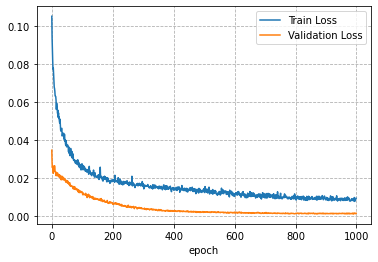

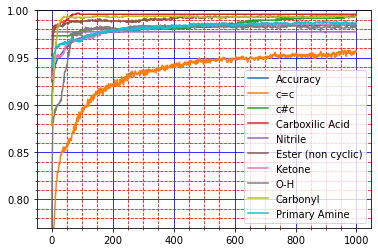

In [16]:
xaxis=torch.arange(0, epochs, 1)

plt.plot(xaxis.numpy(), loss_train, label='Train Loss')
plt.plot(xaxis.numpy(), loss_val, label='Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid(linestyle = '--')
plt.show()
                                    
plt.plot(xaxis.numpy(), accuracy_list, label='Accuracy')
plt.plot(xaxis.numpy(), accuracy_list_bonds[0], label='c=c')
plt.plot(xaxis.numpy(), accuracy_list_bonds[1], label='c#c')
plt.plot(xaxis.numpy(), accuracy_list_bonds[2], label='Carboxilic Acid')
plt.plot(xaxis.numpy(), accuracy_list_bonds[3], label='Nitrile')
plt.plot(xaxis.numpy(), accuracy_list_bonds[4], label='Ester (non cyclic)')
plt.plot(xaxis.numpy(), accuracy_list_bonds[5], label='Ketone')
plt.plot(xaxis.numpy(), accuracy_list_bonds[6], label='O-H')
plt.plot(xaxis.numpy(), accuracy_list_bonds[7], label='Carbonyl')
plt.plot(xaxis.numpy(), accuracy_list_bonds[8], label='Primary Amine')
plt.rcParams["figure.figsize"] = (15,10)
plt.legend()
#plt.grid(linestyle = '--')
plt.minorticks_on()
plt.grid(b=True, which='major', color='b', linestyle='-')
plt.grid(b=True, which='minor', color='r', linestyle='--')
plt.ylim(0.77,1)
plt.show()

Print the last value of accuracy

In [17]:
accuracy_list[-1]

tensor(0.9847)

From the training and validation Loss vs Epoch graph, one can evidence the positive impact of dropout, the algorithm seems to converge without overfitting, indefinitely. 

Lets write a script that will calculate the percentage of correctly classified as present and correctly classified as absent for a given functional group

In [18]:
#0: c=c, 1: c#c, 2: Carboxilyc Acid, 3: Nitrile, 4: Ester(non cyclic), 5: Ketone, 6: O-H, 7: Carbonyl, 8: Primary Amine

functional_group=4 #Ester

present_c=0
present_incorrect=0

absent_correct=0
absent_incorrect=0

for x in range(967):
    spectra=val_set[x][0].view(-1,1,825)
    spectra=spectra.to(device)
    result=torch.round(model(spectra))
    true=val_set[x][1][functional_group]
    true=true.to(device)
    
    if true==result[0][functional_group] and result[0][functional_group]==1:
        present_c+=1
    if true!=result[0][functional_group] and result[0][functional_group]==1: 
        present_incorrect+=1
    if true==result[0][functional_group] and result[0][functional_group]==0:
        absent_correct+=1
    if true!=result[0][functional_group] and result[0][functional_group]==0: 
        absent_incorrect+=1

print('correctly classified as present: ', present_c/(present_c+present_incorrect))
print('correctly classified as absent: ', absent_correct/(absent_correct+absent_incorrect))

correctly classified as present:  0.9615384615384616
correctly classified as absent:  0.9976825028968713


Finally let's see the percentage of compounds the model was able to classify without any mistake (meaning, all present and absent bonds/functional groups correctly predicted as either present or absent

In [19]:
#view identity of exact matching tensors
c=0
for x in range(967):
    spectra=val_set[x][0].view(-1,1,825)
    spectra=spectra.to(device)
    result=torch.round(model(spectra))
    true=val_set[x][1]
    true=true.to(device)
    
    var=(true==result[0]).sum()
    
    if var==torch.tensor(9):
        c+=1

print('Accuracy at predicting all 9 outputs correctly: ', (c)/967)

Accuracy at predicting all 9 outputs correctly:  0.8810754912099276
